 # Machine learning methods for the analysis of bacterial genomes: classification using Random Forest

We provide here a workflow for machine learning (ML) classification of binary outcomes (e.g. healthy/sick, presence/absence, yes/no) based on a set of features or predictors (e.g. metadata) using random forest.

To test this workflow we used a random subset (subset.csv) of the dataset utilized in Bobbo et al. (2024; https://doi.org/10.1186/s12864-024-10832-y), a study which aimed to apply ML algorithms to replicate the accurate classification of archaea and bacteria and to extract the relevant genomic features that drive their classification. Archaea and Bacteria are distinct domains of life that are adapted to a variety of ecological niches. Several genome-based methods have been developed for their accurate classification, yet many aspects of the specific genomic features that determine these differences are not fully understood. In Bobbo et al. (2024), we used publicly available whole-genome sequences from bacteria and archaea. From these, a set of genomic features (nucleotide frequencies and proportions, coding sequences (CDS), non-coding, ribosomal and transfer RNA genes (ncRNA, rRNA, tRNA), Chargaff’s, topological entropy and Shannon’s entropy scores) was extracted using GBRAP tool and used as input data to develop ML models for the classification of archaea and bacteria.
For this workflow, the input dataset should include, in order: binary Outcome (e.g., Archaea/Bacteria), ID (e.g., sample ID), features/predictors. A total of 363 records (109 Archaea and 254 Bacteria) and 79 genomic features (numerical variables) were considered in "subset.csv".

## Install libraries
Install required libraries.

In [2]:
install.packages('vip')
install.packages('randomForest')
#install.packages('ggplot2') already installed
#install.packages('tidyverse') already installed
#install.packages('data.table') already installed
install.packages('tidymodels')
install.packages('themis')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Load libraries
Load required libraries.

In [3]:
library("vip")
library("randomForest")
library("ggplot2")
library("tidyverse")
library("data.table")
library("tidymodels")
library("themis")  # for step_upsample


Attaching package: ‘vip’


The following object is masked from ‘package:utils’:

    vi


randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.1.0     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine()  masks randomForest::combine()
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ ggplot2::margin() masks randomForest::margin()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, min

## Parameters setting
The parameters that the user have to set prior to the analysis are listed below:

- input_file: input dataset
- split_ratio: dataset train/test split proportion (e.g., 80:20 = 0.80, 70:30 = 0.70);
- k_folds: number of folds in (repeated) K-fold crossvalidation  (e.g., 3,5,10);
- nrepeats_cv: number of k-fold crossvalidation repeats (e.g., 10,100,1000; 1 is recommended as a first test) during model training;

The ML analysis is performed using the R Tidymodels package and detailed information can be found at https://www.tidymodels.org/.

In [4]:
input_file = "https://raw.githubusercontent.com/taniabobbo/AGRISYSTEM_PhD_School_Piacenza/refs/heads/main/subset.csv"
split_ratio = 0.80
k_folds = 10
nrepeats_cv = 3

## Import dataset
- Import dataset : specify "." for decimals; ".", "-", "NA" will be considered as missing values; convert character columns to factors
- Check dataset dimension (number of records and columns)
- Visualize first six records
- Check structure of the dataset : binary outcome and ID should be considered as factors, features can be all numeric (e.g, height, weight), all factors (e.g., sex) or both.


In [5]:
dataset <- fread(input_file, dec = ".", na.strings = c(".", "-", "NA"), stringsAsFactors = TRUE)
dim(dataset)
head(dataset)
str(dataset)

[1] 363  79

Outcome,ID,bp_genA,bp_genT,bp_genC,bp_genG,bp_genome_total,fr_genA,fr_genT,fr_genC,⋯,bp_rRNA_G,bp_rRNA_total,fr_rRNA_A,fr_rRNA_T,fr_rRNA_C,fr_rRNA_G,rRNA_topological_entropy_score,rRNA_chargaff_score_pf,rRNA_chargaff_score_ct,rRNA_shannon_score
<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Archaea,NC_013741,452769,452260,326684,328909,1560622,0.29,0.29,0.21,⋯,1680,4610,0.21,0.14,0.29,0.36,0.8865,0.2936,0.7477,1.9147
Archaea,NC_015320,500556,506542,447794,447051,1901943,0.26,0.27,0.24,⋯,1640,4573,0.21,0.16,0.28,0.35,0.8914,0.2527,0.7775,1.9350
Archaea,NZ_CP012850,1129864,1129640,585429,585773,3430706,0.33,0.33,0.17,⋯,4083,13391,0.25,0.20,0.24,0.31,0.9176,0.2240,0.8011,1.9811
Archaea,NZ_CP021324,464438,468067,215792,211779,1360076,0.34,0.34,0.16,⋯,1329,4588,0.26,0.23,0.23,0.29,0.9252,0.1873,0.8325,1.9908
Archaea,NZ_CP007026,411277,412305,205756,202790,1232128,0.33,0.33,0.17,⋯,1338,4597,0.26,0.23,0.23,0.29,0.9155,0.1908,0.8302,1.9900
Archaea,NC_013849,615993,610942,481744,487587,2196266,0.28,0.28,0.22,⋯,1677,4613,0.20,0.15,0.30,0.36,0.8914,0.2525,0.7781,1.9205


Classes ‘data.table’ and 'data.frame':	363 obs. of  79 variables:
 $ Outcome                          : Factor w/ 2 levels "Archaea","Bacteria": 1 1 1 1 1 1 1 1 1 1 ...
 $ ID                               : Factor w/ 363 levels "NC_000868","NC_000961",..: 26 43 117 144 90 29 276 235 314 47 ...
 $ bp_genA                          : int  452769 500556 1129864 464438 411277 615993 540494 529142 559392 543585 ...
 $ bp_genT                          : int  452260 506542 1129640 468067 412305 610942 543513 524146 563638 543939 ...
 $ bp_genC                          : int  326684 447794 585429 215792 205756 481744 963601 944176 1118858 954961 ...
 $ bp_genG                          : int  328909 447051 585773 211779 202790 487587 964652 942764 1112766 952786 ...
 $ bp_genome_total                  : int  1560622 1901943 3430706 1360076 1232128 2196266 3012260 2940228 3354654 2995271 ...
 $ fr_genA                          : num  0.29 0.26 0.33 0.34 0.33 0.28 0.18 0.18 0.17 0.18 ...
 $ fr_gen

## Dataset preprocessing : missing values
This workflow works only with complete datasets (no missing values), so sanity check before running the analysis in required.


In [6]:
# Sanity check

if (sum(is.na(dataset)) == 0) {
  print("No missing data in the dataset: OK! Go to 'Dataset preprocessing : descriptive statistics'")
} else {
  print("Missing data in the dataset: please remove them! Go to 'Keep only complete records' cell")
}

[1] "No missing data in the dataset: OK! Go to 'Dataset preprocessing : descriptive statistics'"


If there are no missing values, proceed with the analysis.
If missing values are detected after the sanity check, please remove them with the appropriate code using complete.cases().

In [7]:
# Keep only complete records and check dataset dimension

dataset <- dataset[complete.cases(dataset), ]
dim(dataset)

[1] 363  79

## Dataset preprocessing : descriptive statistics
Descriptive statistics (frequencies or distribution) of all variables.


In [8]:
summary(dataset)

     Outcome            ID         bp_genA           bp_genT       
 Archaea :109   NC_000868:  1   Min.   : 209417   Min.   : 205352  
 Bacteria:254   NC_000961:  1   1st Qu.: 579840   1st Qu.: 579332  
                NC_003106:  1   Median : 792628   Median : 789428  
                NC_003155:  1   Mean   : 892227   Mean   : 892473  
                NC_003551:  1   3rd Qu.:1143596   3rd Qu.:1146912  
                NC_003552:  1   Max.   :2053795   Max.   :2065245  
                (Other)  :357                                      
    bp_genC           bp_genG        bp_genome_total       fr_genA     
 Min.   : 116577   Min.   : 114184   Min.   :  847967   Min.   :0.130  
 1st Qu.: 528144   1st Qu.: 530260   1st Qu.: 2606698   1st Qu.:0.190  
 Median : 944176   Median : 942764   Median : 3456765   Median :0.240  
 Mean   :1023610   Mean   :1023380   Mean   : 3833979   Mean   :0.245  
 3rd Qu.:1279536   3rd Qu.:1278796   3rd Qu.: 4782806   3rd Qu.:0.300  
 Max.   :5241445   Max. 

## Machine learning analysis


### Training/test split

The dataset will be splitted into a subset used to train and validate the model, and a subset that will be used to test the model's performance


In [9]:
# parameter "split_ratio" will be applied to choose the ratio used to split tha dataset by outcome (e.g., 80:20, 70:30)

rf_dt <- select(dataset, -c(ID))
rf_split <- initial_split(rf_dt, strata = Outcome, prop = split_ratio)
rf_train <- training(rf_split)
rf_test <- testing(rf_split)

# Sanity check on outcome frequencies in train and test sets

rf_train %>% count(Outcome) |> print()
rf_test %>% count(Outcome) |> print()

    Outcome     n
     <fctr> <int>
1:  Archaea    87
2: Bacteria   203
    Outcome     n
     <fctr> <int>
1:  Archaea    22
2: Bacteria    51


## Preprocessing

We use Tidymodels to build a recipe for data preprocessing:
 -   remove correlated variables
 -   remove non informative variables (zero variance)
 -   upsampling to handle output class imbalance
 -   standardize all variables

In [10]:
rf_recipe <- rf_train %>%
  recipe(Outcome ~ .) %>%
  step_corr(all_predictors(), threshold = 0.99) %>%
  step_zv(all_numeric(), -all_outcomes()) %>%
  step_upsample(Outcome, over_ratio = 1, seed = 123) %>%
  step_normalize(all_numeric(), -all_outcomes())

prep_rf <- prep(rf_recipe)
print(prep_rf)

training_set <- juice(prep_rf) # Extract transformed training set
head(training_set)



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:    1
predictor: 77



── Training information 

Training data contained 290 data points and no incomplete rows.



── Operations 

• Correlation filter on: bp_genT, bp_genG, fr_genG, ... | Trained

• Zero variance filter removed: <none> | Trained

• Up-sampling based on: Outcome | Trained

• Centering and scaling for: bp_genA bp_genome_total, ... | Trained



bp_genA,bp_genome_total,genomic_topological_entropy_score,genomic_chargaff_score_pf,genomic_shannon_score,n_cds_plus,bp_cdsA,bp_cdsT,bp_cdsC,bp_cds_total,⋯,n_rRNA_minus,bp_rRNA_C,fr_rRNA_A,fr_rRNA_T,fr_rRNA_C,fr_rRNA_G,rRNA_topological_entropy_score,rRNA_chargaff_score_pf,rRNA_shannon_score,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.4065220,0.2277310,-0.3322572,-0.4448418,-0.5674115,0.5085703,-0.3318590,-0.4090785,0.5818387,0.2676067,⋯,-0.5469917,-0.1006228,-0.1890318,-0.9552036,1.251383,-0.184909,-1.2386295,0.6924467,-0.4751103,Archaea
-0.8724471,-0.8793641,0.6603353,0.4566845,1.1543193,-1.2389916,-1.2204603,-1.2671239,-0.8974810,-1.1614138,⋯,-0.7783236,-0.9177584,-2.0700840,-2.2598720,1.891663,2.223852,-2.3047196,0.5500883,-2.9690121,Archaea
-1.0555035,-1.2734869,-0.5276738,0.8052747,-0.7894112,-1.3756137,-1.0091752,-1.0588217,-1.1542090,-1.2372093,⋯,-0.5469917,-0.4592982,-1.3176631,-1.6075378,1.571523,1.420932,-1.2919340,0.2965124,-1.6093232,Archaea
-0.6433038,-0.8765091,0.3842705,-0.2164551,0.6708534,-0.7525568,-0.4093380,-0.5609519,-0.8224979,-0.7594915,⋯,-1.0096555,-0.9594009,-2.4462944,-1.2813707,1.571523,2.223852,-0.9454547,-1.3027952,-2.2960002,Archaea
-0.6376577,-0.9069779,0.3408446,1.5264957,0.4809203,-0.7240313,-0.4317041,-0.5715759,-0.8608852,-0.7991126,⋯,-0.5469917,-0.9597938,-2.0700840,-1.6075378,1.571523,2.223852,-2.0826175,-0.7845216,-2.3164981,Archaea
-0.5657113,-0.7681145,0.4090853,0.3965827,0.9101197,-0.4057469,-0.2930997,-0.5321686,-0.7426232,-0.6502247,⋯,-1.0096555,-0.9759008,-1.3176631,-1.2813707,1.251383,1.822392,-1.2652818,0.4099543,-1.3735982,Archaea


## Model building

### Model training
We now specify the structure of our model:
-   hyperparameters to tune: `mtry` (number of features to sample for each tree) and `min_n` (minimum number of data points in a node to allow further splitting)
-   number of trees in the forest
-   the problem at hand (classification)
-   the engine (R package)

Then we put this in a workflow together with the preprocessing recipe.

In [12]:
tune_spec <- rand_forest(
  mtry = tune(),
  trees = 500,
  min_n = tune()
) %>%
  set_mode("classification") %>%
  set_engine("randomForest")

tune_wf <- workflow() %>%
  add_formula(Outcome ~ .) %>%
  add_model(tune_spec)


### Tuning of hyperparameters
We use k-fold cross-validation to tune the hyperparameters in the training set.

[1] 7


mtry,min_n
<int>,<int>
2,2
4,2
7,2
9,2
12,2
2,4


[1] 25

# A tibble: 75 × 8
    mtry min_n .metric  .estimator  mean     n std_err .config              
   <int> <int> <chr>    <chr>      <dbl> <int>   <dbl> <chr>                
 1     2     2 accuracy binary     0.998    30 0.00113 Preprocessor1_Model01
 2     2     2 mcc      binary     0.997    30 0.00221 Preprocessor1_Model01
 3     2     2 roc_auc  binary     1        30 0       Preprocessor1_Model01
 4     4     2 accuracy binary     0.998    30 0.00114 Preprocessor1_Model02
 5     4     2 mcc      binary     0.997    30 0.00242 Preprocessor1_Model02
 6     4     2 roc_auc  binary     1        30 0       Preprocessor1_Model02
 7     7     2 accuracy binary     1        30 0       Preprocessor1_Model03
 8     7     2 mcc      binary     1        30 0       Preprocessor1_Model03
 9     7     2 roc_auc  binary     1        30 0       Preprocessor1_Model03
10     9     2 accuracy binary     1        30 0       Preprocessor1_Model04
# ℹ 65 more rows


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


mtry,min_n,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,2,mcc,binary,1,30,0,Preprocessor1_Model03
9,2,mcc,binary,1,30,0,Preprocessor1_Model04
7,4,mcc,binary,1,30,0,Preprocessor1_Model08
9,4,mcc,binary,1,30,0,Preprocessor1_Model09
9,6,mcc,binary,1,30,0,Preprocessor1_Model14


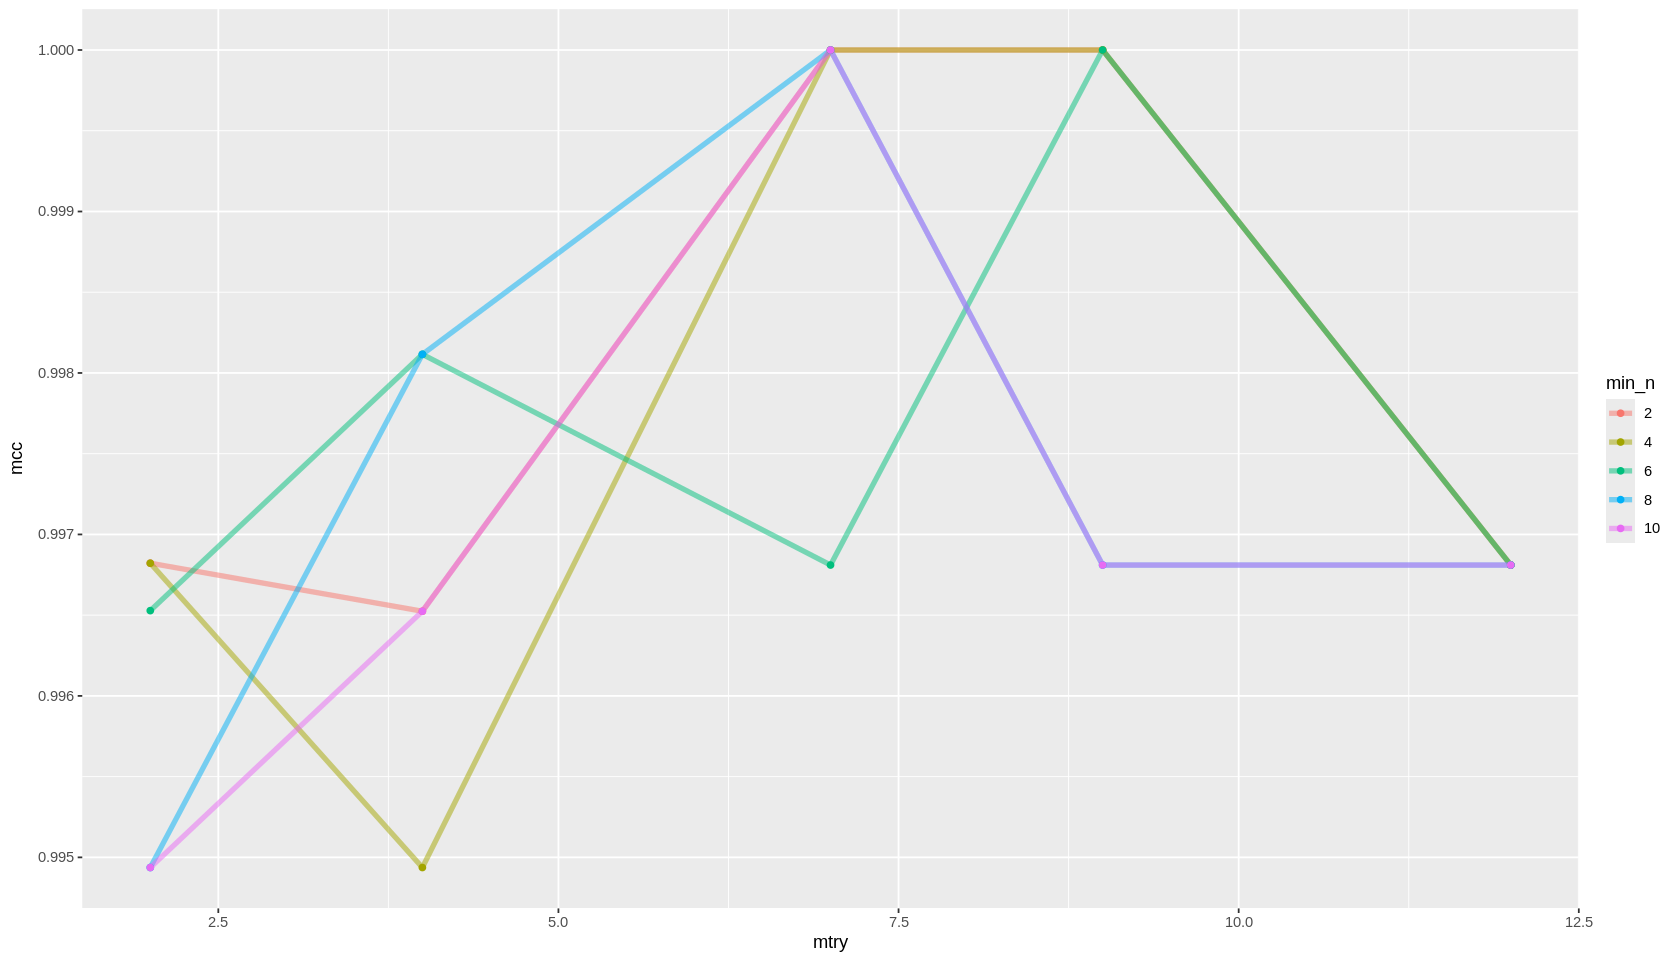

In [13]:
# Parameters "k_folds" and "nrepeats_cv" will be applied to choose number of folds in (repeated) K-fold crossvalidation
# and number of k-fold crossvalidation repeats during model training.
# Several metrics (e.g. accuracy, AUC, MCC) will be calculated.

set.seed(123)
trees_folds <- vfold_cv(training_set, v = k_folds, repeats = nrepeats_cv)

# In Random Forest models, mtry is the number of features randomly selected at each split.
# A common rule of thumb for classification is √p, where p is the number of predictors (excluding the target).
# ncol(training_set)-1 excludes the target variable from the count.

m <- round(sqrt(ncol(training_set)-1),0)
print(m)

rf_grid <- grid_regular(
  mtry(range = c(m-5, m+5)),
  min_n(range = c(2, 10)),
  levels = c(5,5) # 5 different values will be generated evenly spaced between m-5 and m+5 (mtry) and 2 and 10  (min_n)
)

# Displays the first few rows of the grid and the total number of combinations.

head(rf_grid)
nrow(rf_grid)

# Performs model tuning using the tune_wf workflow.
# Evaluation metrics:
# - roc_auc: Area Under the ROC Curve.
# - accuracy: Overall classification accuracy.
# - mcc: Matthews Correlation Coefficient (great for imbalanced datasets).

regular_res <- tune_grid(
  tune_wf,
  metrics = metric_set(roc_auc, accuracy, mcc),
  resamples = trees_folds,  # provides the cross-validation strategy
  grid = rf_grid
)

# Collects and prints the average performance metrics for each combination of hyperparameters

regular_res |>
  collect_metrics() |>
  print()


# Plots the MCC metric across different values of mtry, grouped by min_n.
# Helps visualize which hyperparameter combinations performed best.

library("repr")
options(repr.plot.width=14, repr.plot.height=8)

regular_res %>%
  collect_metrics() %>%
  filter(.metric == "mcc") %>%
  mutate(min_n = factor(min_n)) %>%
  ggplot(aes(mtry, mean, color = min_n)) +
  geom_line(alpha = 0.5, size = 1.5) +
  geom_point() +
  labs(y = "mcc")

# Selects the best performing parameter set based on the MCC score.

best_auc <- select_best(x = regular_res, metric = "mcc")
show_best(regular_res, metric = "mcc") # Lists the top combinations ranked by MCC.

### Final model

In [14]:
# It replaces the placeholders with the best values, creating the final tuned model.

final_rf <- finalize_model(
  tune_spec,  # your model specification with placeholder hyperparameters
  best_auc  # the best hyperparameter combination found during tuning (in this case, chosen using MCC metric earlier)
)

print(final_rf)


# Finalise the workflow including the final RF model and fit it to the initial split (training and test data):

final_wf <- workflow() %>%
  add_recipe(rf_recipe) %>%
  add_model(final_rf)

# Fits the finalized workflow to the training portion of rf_split and evaluates the model on the test portion of rf_split.

final_res <- final_wf %>%
  last_fit(rf_split, metrics = metric_set(roc_auc, accuracy, mcc, brier_class))

# Evaluate the fine-tuned rf model

print(final_res)
final_res %>%
  collect_metrics()

Random Forest Model Specification (classification)

Main Arguments:
  mtry = 7
  trees = 500
  min_n = 2

Computational engine: randomForest 

# Resampling results
# Manual resampling 
# A tibble: 1 × 6
  splits           id               .metrics .notes   .predictions .workflow 
  <list>           <chr>            <list>   <list>   <list>       <list>    
1 <split [290/73]> train/test split <tibble> <tibble> <tibble>     <workflow>


.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.95890411,Preprocessor1_Model1
mcc,binary,0.90161846,Preprocessor1_Model1
roc_auc,binary,0.99732620,Preprocessor1_Model1
brier_class,binary,0.02071112,Preprocessor1_Model1


## Get variable importance

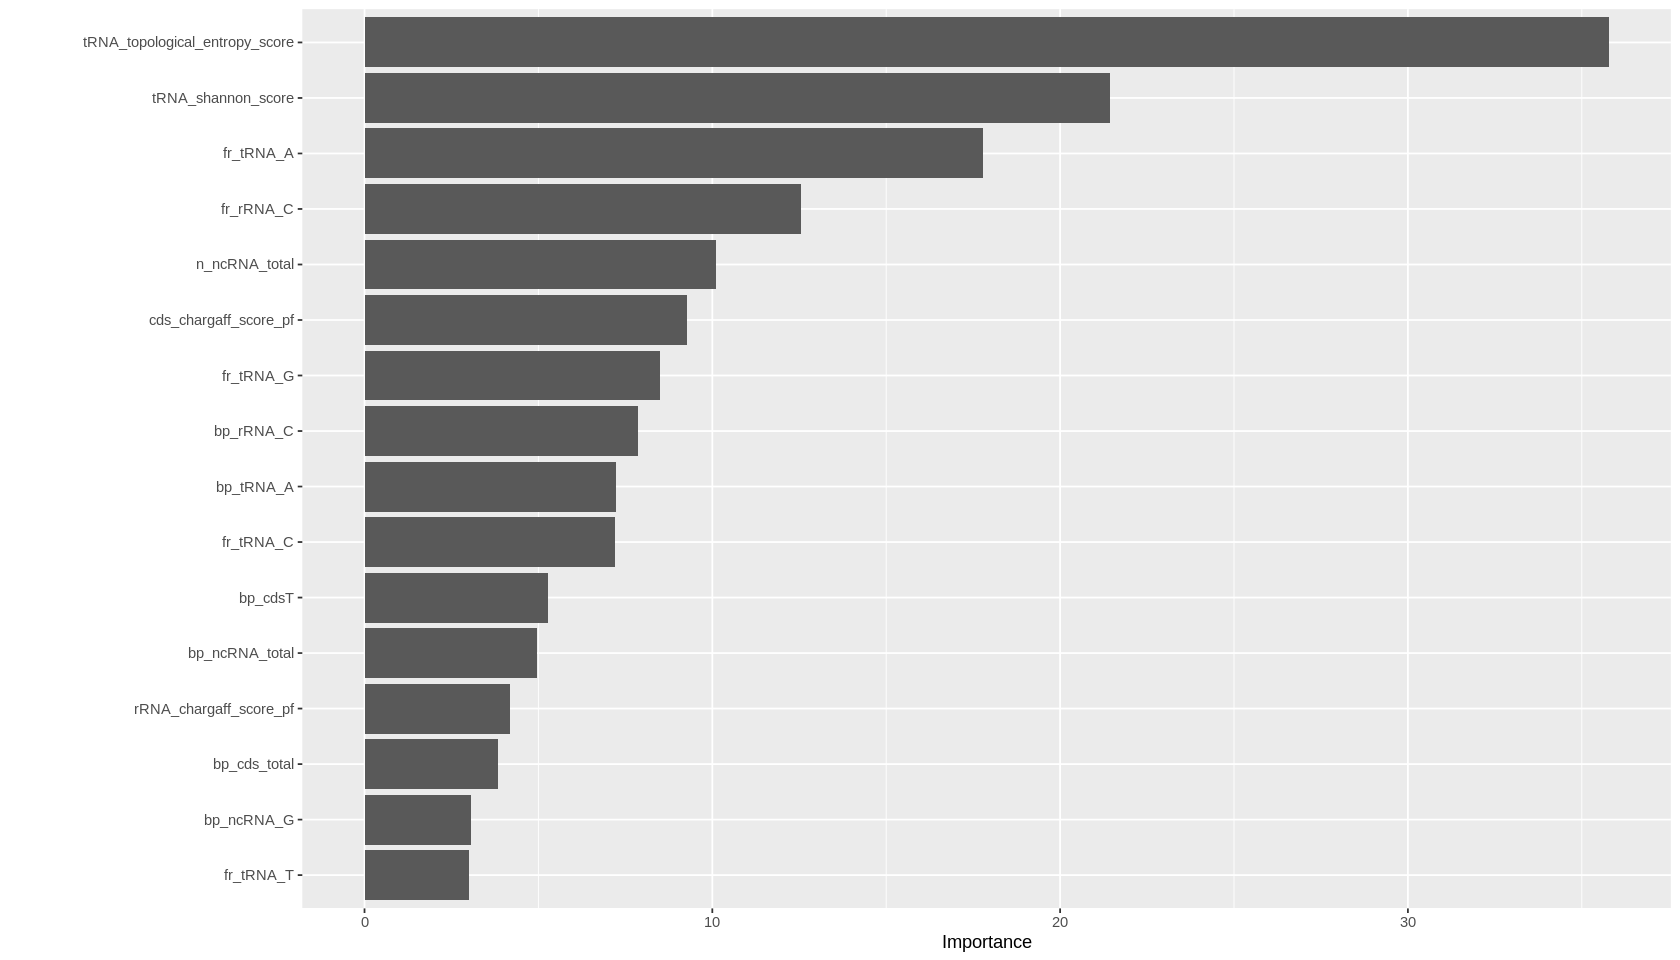

In [15]:
final_res %>%
  pluck(".workflow", 1) %>%
  extract_fit_parsnip() %>%
  vip(num_features = 16)

## Predictions on test set

The predictive ability of the ML methods on the test set (final evaluation of model performance) will be assessed based on several metrics obtained from the confusion matrix, including accuracy, sensitivity, specificity and the Matthew’s Correlation Coefficient ("MCC").

In [16]:
# We collect the predictions on the test set

final_res %>%
  collect_predictions()

cm <- final_res %>%
  collect_predictions() %>%
  conf_mat(Outcome, .pred_class)

print(cm)

# Calculate classification metrics on test set
# "Bacteria" is the positive class when using event_level = "second"

test_metrics <- final_res %>%
  collect_predictions() %>%
  summarise(
    accuracy = accuracy_vec(truth = Outcome, estimate = .pred_class),
    sensitivity = sens_vec(truth = Outcome, estimate = .pred_class, event_level = "second"),
    specificity = spec_vec(truth = Outcome, estimate = .pred_class, event_level = "second"),
    mcc = mcc_vec(truth = Outcome, estimate = .pred_class)
  )

print("Test set metrics:")
print(test_metrics)


print("DONE!!")

.pred_class,.pred_Archaea,.pred_Bacteria,id,.row,Outcome,.config
<fct>,<dbl>,<dbl>,<chr>,<int>,<fct>,<chr>
Archaea,0.856,0.144,train/test split,5,Archaea,Preprocessor1_Model1
Archaea,0.974,0.026,train/test split,7,Archaea,Preprocessor1_Model1
Archaea,0.994,0.006,train/test split,8,Archaea,Preprocessor1_Model1
Archaea,0.952,0.048,train/test split,17,Archaea,Preprocessor1_Model1
Archaea,0.970,0.030,train/test split,37,Archaea,Preprocessor1_Model1
Bacteria,0.184,0.816,train/test split,41,Archaea,Preprocessor1_Model1
Archaea,0.956,0.044,train/test split,42,Archaea,Preprocessor1_Model1
Archaea,0.902,0.098,train/test split,54,Archaea,Preprocessor1_Model1
Archaea,0.956,0.044,train/test split,62,Archaea,Preprocessor1_Model1


          Truth
Prediction Archaea Bacteria
  Archaea       20        1
  Bacteria       2       50
[1] "Test set metrics:"
# A tibble: 1 × 4
  accuracy sensitivity specificity   mcc
     <dbl>       <dbl>       <dbl> <dbl>
1    0.959       0.980       0.909 0.902
[1] "DONE!!"


## Save workspace

In [ ]:
save.image("rf_workshop.RData")